### Importing necessary modules

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Importing the data

In [137]:
# Merge the datasets by the same PlayGuid
steal_play_metrics = pd.read_csv("/Users/neel/Downloads/StealContext.csv")
steal_context = pd.read_csv("/Users/neel/Downloads/StealPlayMetrics.csv")

df = pd.merge(steal_play_metrics, steal_context, on='PlayGuid')

In [197]:
# Make a copy of the dataframe
df.copy()

,AwayTeam,HomeTeam,GameTime,Inning,InningTop,VisitingScore,HomeScore,Balls,Strikes,OutsBefore,...,Pop_Time,PickOff_Steal_Exchange,Year,Month,DayOfWeek,Hour,StealPickoff,Base,HomeCode,AwayCode
0,NYM,WSH,2019-03-28 13:05:00,6,0,1,0,1,0,0,...,1.938,0.705,2019,3,3,13,0,2,0,18
1,NYM,WSH,2019-03-28 13:05:00,1,0,1,0,0,0,2,...,1.973,0.715,2019,3,3,13,0,2,0,18
2,NYM,WSH,2019-03-28 13:05:00,9,1,2,0,0,1,2,...,0.000,0.000,2019,3,3,13,0,2,0,18
3,NYM,WSH,2019-03-28 13:05:00,6,0,1,0,2,2,1,...,1.574,0.693,2019,3,3,13,0,3,0,18
4,LAA,OAK,2019-03-28 13:07:00,3,0,0,1,0,2,1,...,2.009,0.658,2019,3,3,13,0,2,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8117,TB,NYY,2021-10-03 15:05:00,8,1,0,0,0,1,0,...,1.952,0.778,2021,10,6,15,0,2,13,6
8119,BAL,TOR,2021-10-03 15:07:00,3,0,1,5,2,2,0,...,2.525,1.258,2021,10,6,15,0,2,5,19
8120,PHI,MIA,2021-10-03 15:10:00,8,0,4,5,1,0,0,...,1.930,0.701,2021,10,6,15,0,2,10,3
8121,PHI,MIA,2021-10-03 15:10:00,8,1,3,5,1,2,0,...,0.000,0.000,2021,10,6,15,0,2,10,3


### Cleaning the data

#### Converting columns to the appropriate data type

In [139]:
# Observe the data types
df.dtypes

AwayTeam                    object
HomeTeam                    object
GameTime                    object
Inning                       int64
InningTop                    int64
VisitingScore                int64
HomeScore                    int64
Balls                        int64
Strikes                      int64
OutsBefore                   int64
PitchHand                   object
BatHand                     object
BallparkId                   int64
PlayDescription             object
PlayDetailType              object
PlayGuid                    object
StartRunnerOnFirstId       float64
StartRunnerOnSecondId      float64
StartRunnerOnThirdId       float64
Advance                      int64
ThrownOut                    int64
RunnerId                     int64
PitcherId                  float64
CatcherId                  float64
Lead_Distance              float64
Secondary_Lead_Distance    float64
Plate_Time_y0              float64
Plate_Time_y17             float64
Pop_Time            

In [140]:
# Create new columns out of GameTime to use in the model

# Convert GameTime to date-time format
df["GameTime"] = pd.to_datetime(df["GameTime"])

# Create the columns
df['Year'] = df['GameTime'].dt.year
df['Month'] = df['GameTime'].dt.month
df['DayOfWeek'] = df['GameTime'].dt.dayofweek
df['Hour'] = df['GameTime'].dt.hour

# Convert the newly created columns to integer type
df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)
df['DayOfWeek'] = df['DayOfWeek'].astype(int)
df['Hour'] = df['Hour'].astype(int)

In [141]:
# Convert 'PitchHand' and 'BatHand' to binary

df["PitchHand"] = df["PitchHand"].replace({"^R$": 1, "^L$": 0}, regex=True)
df["BatHand"] = df["BatHand"].replace({"^R$": 1, "^L$": 0}, regex=True)

In [142]:
# Create 'StealPickoff' and 'Base' columns from 'PlayDetailType'

df["StealPickoff"] = df["PlayDetailType"].str.startswith("pickoff").astype(int)
 
df["Base"] = df["PlayDetailType"].str.extract(r"(\d)").astype(float)  
df["Base"] = df["Base"].fillna(0)  
df["Base"] = df["Base"].astype(int)

In [143]:
# Create codes for teams

df["HomeCode"] = df["HomeTeam"].astype("category").cat.codes
df["AwayCode"] = df["AwayTeam"].astype("category").cat.codes

# Create a mapping dictionary for teams and their corresponding codes
team_mapping = dict(zip(df["HomeTeam"].unique(), range(len(df["HomeTeam"].unique()))))

# Apply the mapping to the "HomeTeam" and "AwayTeam" columns
df["HomeCode"] = df["HomeTeam"].map(team_mapping)
df["AwayCode"] = df["AwayTeam"].map(team_mapping)

# Observe which team is which code
reverse_team_mapping = {v: k for k, v in team_mapping.items()}

for code, team in reverse_team_mapping.items():
    print(f"{code}: {team}")

0: WSH
1: OAK
2: TEX
3: PHI
4: KC
5: TOR
6: TB
7: CIN
8: SEA
9: SD
10: MIA
11: MIL
12: LAD
13: NYY
14: PIT
15: CLE
16: ATL
17: DET
18: NYM
19: BAL
20: CWS
21: SF
22: ARI
23: LAA
24: HOU
25: STL
26: COL
27: BOS
28: CHC
29: MIN


#### Removing NaN rows

In [155]:
# Observe the number of NaN rows for each column

nan_counts = df.isna().sum()
print(nan_counts)

AwayTeam                   0
HomeTeam                   0
GameTime                   0
Inning                     0
InningTop                  0
VisitingScore              0
HomeScore                  0
Balls                      0
Strikes                    0
OutsBefore                 0
PitchHand                  0
BatHand                    0
BallparkId                 0
PlayDescription            0
PlayDetailType             0
PlayGuid                   0
StartRunnerOnFirstId       0
StartRunnerOnSecondId      0
StartRunnerOnThirdId       0
Advance                    0
ThrownOut                  0
RunnerId                   0
PitcherId                  0
CatcherId                  0
Lead_Distance              0
Secondary_Lead_Distance    0
Plate_Time_y0              0
Plate_Time_y17             0
Pop_Time                   0
PickOff_Steal_Exchange     0
Year                       0
Month                      0
DayOfWeek                  0
Hour                       0
StealPickoff  

In [145]:
# Remove rows for columns that have relatively few NaN values

columns_to_check = ["Secondary_Lead_Distance", "Plate_Time_y0", "Plate_Time_y17", "PitcherId"]
df = df.dropna(subset=columns_to_check, how='any')

In [146]:
# Fill NaN values with 0 
df['StartRunnerOnFirstId'].fillna(0, inplace=True)
df['StartRunnerOnSecondId'].fillna(0, inplace=True)
df['StartRunnerOnThirdId'].fillna(0, inplace=True)
df['CatcherId'].fillna(0, inplace=True)
df['Pop_Time'].fillna(0, inplace=True)
df['PickOff_Steal_Exchange'].fillna(0, inplace=True)

In [147]:
# Observe the number of rows and columns
df.shape

(7688, 38)

### Creating the model

In [148]:
# Assign our predictors

# Filter columns that are numeric and do not have NaN values
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
numeric_columns_notna = df[numeric_columns].notna().all()
selected_columns = numeric_columns_notna[numeric_columns_notna].index

# Filter out our taregt column
selected_columns = selected_columns.drop(['Advance', 'ThrownOut'])

# Assign the selected columns to our predictors
predictors = selected_columns.tolist()
target = "Advance"

predictors

['Inning',
 'InningTop',
 'VisitingScore',
 'HomeScore',
 'Balls',
 'Strikes',
 'OutsBefore',
 'PitchHand',
 'BatHand',
 'BallparkId',
 'StartRunnerOnFirstId',
 'StartRunnerOnSecondId',
 'StartRunnerOnThirdId',
 'RunnerId',
 'PitcherId',
 'CatcherId',
 'Lead_Distance',
 'Secondary_Lead_Distance',
 'Plate_Time_y0',
 'Plate_Time_y17',
 'Pop_Time',
 'PickOff_Steal_Exchange',
 'Year',
 'Month',
 'DayOfWeek',
 'Hour',
 'StealPickoff',
 'Base',
 'HomeCode',
 'AwayCode']

In [188]:
# Separate the predictors and target variable
X = df[predictors]
y = df[target]

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [189]:
# Create and training the Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)
    
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.52      0.64       349
           1       0.87      0.97      0.92      1189

    accuracy                           0.87      1538
   macro avg       0.85      0.75      0.78      1538
weighted avg       0.86      0.87      0.85      1538



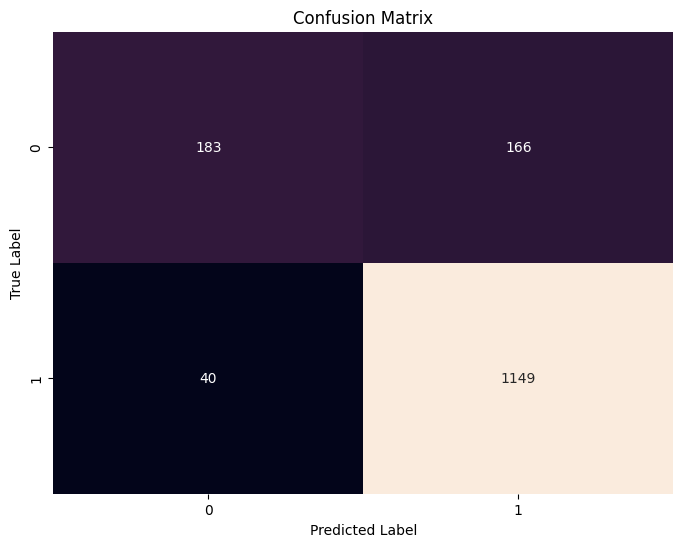

In [201]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [190]:
# Get the feature importances
importances = model.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': predictors, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print(feature_importance_df)


                    Feature  Importance
17  Secondary_Lead_Distance    0.107266
20                 Pop_Time    0.078728
15                CatcherId    0.070683
21   PickOff_Steal_Exchange    0.061399
16            Lead_Distance    0.053651
26             StealPickoff    0.050578
14                PitcherId    0.046005
10     StartRunnerOnFirstId    0.043465
19           Plate_Time_y17    0.043248
18            Plate_Time_y0    0.042234
13                 RunnerId    0.041891
29                 AwayCode    0.034535
28                 HomeCode    0.033928
9                BallparkId    0.032696
0                    Inning    0.026954
3                 HomeScore    0.021796
24                DayOfWeek    0.021582
2             VisitingScore    0.021281
23                    Month    0.021114
4                     Balls    0.021007
12     StartRunnerOnThirdId    0.019186
27                     Base    0.018460
25                     Hour    0.017818
6                OutsBefore    0.013884


### Creating Visualizations

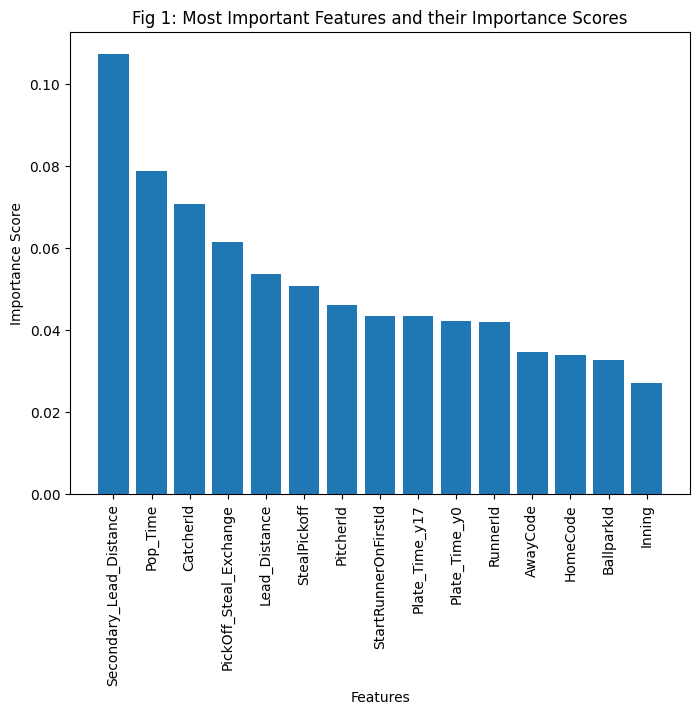

In [307]:
# Extract the top feature names and their importance scores
top_features = feature_importance_df['Feature'].values[:15]
importance_scores = feature_importance_df['Importance'].values[:15]

# Create a bar plot to showcase the top features and their importance scores
plt.figure(figsize=(8, 6))
plt.bar(top_features, importance_scores)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Fig 1: Most Important Features and their Importance Scores')
plt.xticks(rotation=90)
plt.show()

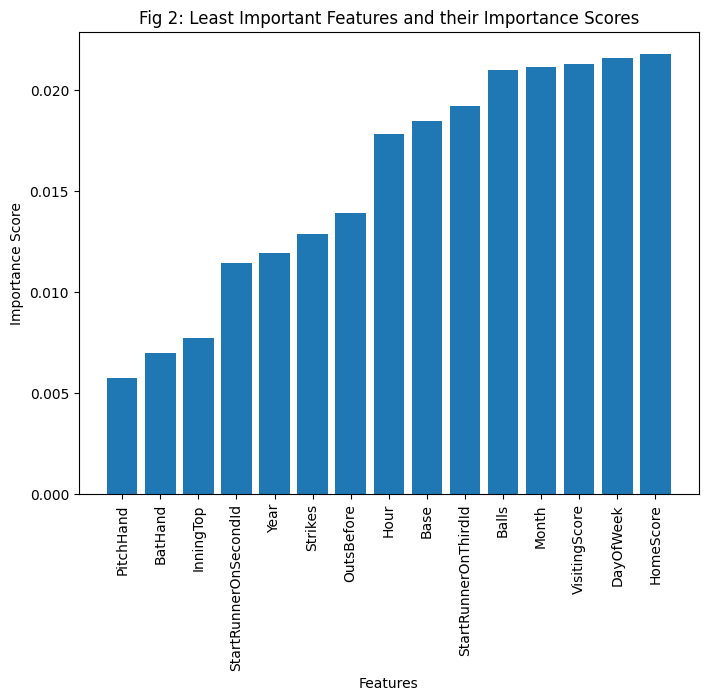

In [308]:
# Sort the feature importance dataframe in ascending order to get the least important features first
least_important_features_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Extract the names and scores of the top 10 least important features
top_least_important_features = least_important_features_df['Feature'].values[:15]
least_importance_scores = least_important_features_df['Importance'].values[:15]

# Create a bar plot to showcase the top 10 least important features and their importance scores
plt.figure(figsize=(8, 6))
plt.bar(top_least_important_features, least_importance_scores)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Fig 2: Least Important Features and their Importance Scores')
plt.xticks(rotation=90)
plt.show()


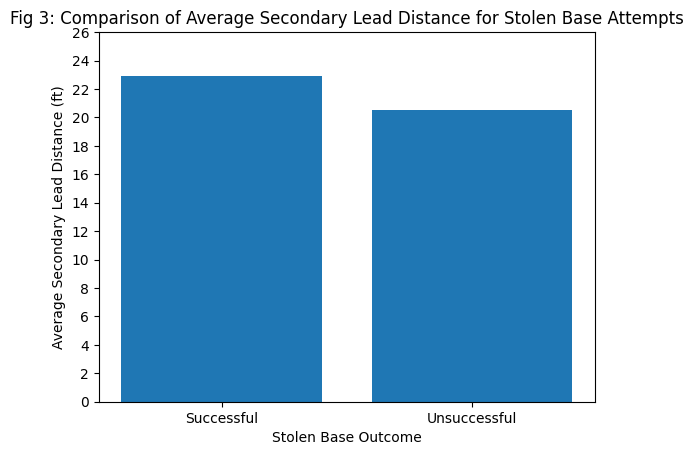

In [309]:
# Subset the data for successful and unsuccessful stolen base attempts
successful_sld = df[df['Advance'] == 1]['Secondary_Lead_Distance']
unsuccessful_sld = df[df['Advance'] == 0]['Secondary_Lead_Distance']

# Calculate the average Secondary Lead Distance for successful and unsuccessful attempts
avg_successful_sld = successful_sld.mean()
avg_unsuccessful_sld = unsuccessful_sld.mean()

# Create the bar chart
plt.bar(['Successful', 'Unsuccessful'], [avg_successful_sld, avg_unsuccessful_sld])
plt.xlabel('Stolen Base Outcome')
plt.ylabel('Average Secondary Lead Distance (ft)')
plt.title('Fig 3: Comparison of Average Secondary Lead Distance for Stolen Base Attempts')

# Set the y-axis ticks with more values
plt.yticks(np.arange(0, 27, 2))  

plt.show()

In [302]:
# Print the average Secondary Lead Distance for successful and unsuccessful attempts
print("Average Secondary Lead Distance for Successful Stolen Base Attempts:", avg_successful_sld)
print("Average Secondary Lead Distance for Unsuccessful Stolen Base Attempts:", avg_unsuccessful_sld)
mean_secondary_lead_distance = df['Secondary_Lead_Distance'].mean()
print("Average Secondary Lead Distance:", mean_secondary_lead_distance)


Average Secondary Lead Distance for Successful Stolen Base Attempts: 22.902974916850688
Average Secondary Lead Distance for Unsuccessful Stolen Base Attempts: 20.532957813750627
Average Secondary Lead Distance: 22.3749000862562


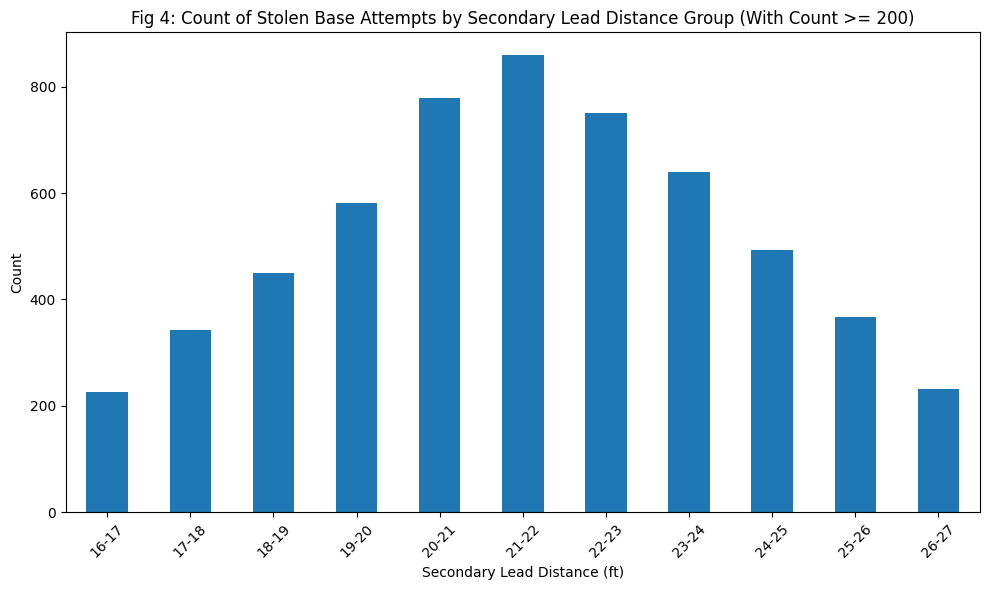

In [310]:
# Define the bins for grouping secondary lead distances
bins = [i for i in range(0, 51, 1)]

# Group the data based on the bins and calculate success rate for each group
df['Lead_Distance_Group'] = pd.cut(df['Secondary_Lead_Distance'], bins)

# Calculate the count of stolen base attempts for each group
group_counts = df.groupby('Lead_Distance_Group')['Advance'].count()

# Filter out groups with a count of at least 200
group_counts = group_counts[group_counts >= 200]

# Create Bar Plot
plt.figure(figsize=(10, 6))
ax = group_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Secondary Lead Distance (ft)')
plt.ylabel('Count')
plt.title('Fig 4: Count of Stolen Base Attempts by Secondary Lead Distance Group (With Count >= 200)')

# Customize x-axis labels
x_labels = [f'{label.left}-{label.right}' for label in group_counts.index]
plt.xticks(range(len(group_counts)), x_labels, rotation=45)

# Show plot
plt.tight_layout()
plt.show()



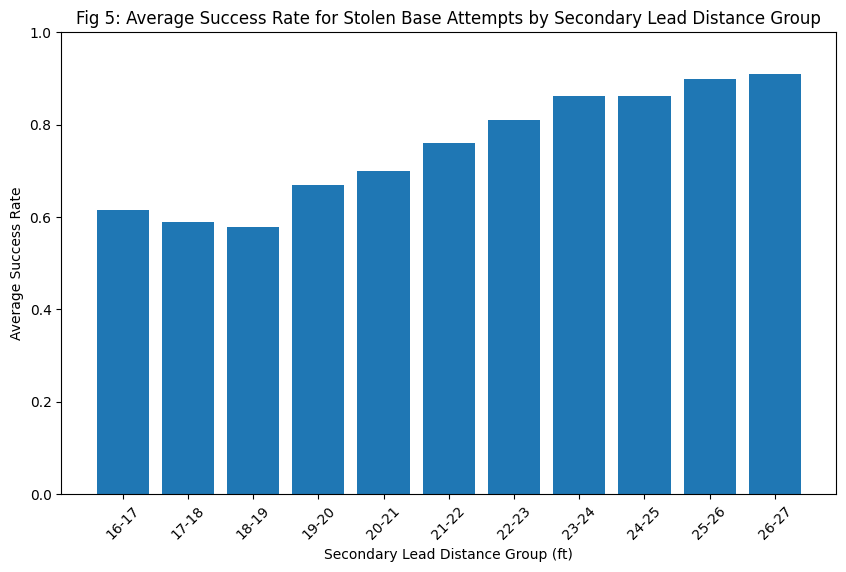

In [311]:
# Define bins for grouping secondary lead distances
bins = [i for i in range(16, 28, 1)]

# Group the data based on the bins and calculate the average success rate for each group
df['Lead_Distance_Group'] = pd.cut(df['Secondary_Lead_Distance'], bins)
success_rate_by_group = df.groupby('Lead_Distance_Group')['Advance'].mean()

# Extract lower and upper bounds of each bin for x-axis labels
x_labels = [f'{int(label.left)}-{int(label.right)}' for label in success_rate_by_group.index]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_labels, success_rate_by_group)
plt.xlabel('Secondary Lead Distance Group (ft)')
plt.ylabel('Average Success Rate')
plt.title('Fig 5: Average Success Rate for Stolen Base Attempts by Secondary Lead Distance Group')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()
